# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.metadata import signal_metadata
from lhcsmapi.pyedsl.dbsignal.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery

from src.acquisitions.current_voltage_diode_leads_nxcals import CurrentVoltageDiodeLeadsNXCALS
from src.acquisitions.current_voltage_diode_leads_pm import CurrentVoltageDiodeLeadsPM
from src.acquisitions.ee_t_res_pm import EETResPM
from src.acquisitions.ee_u_dump_res_pm import EEUDumpResPM
from src.acquisitions.leads import Leads
from src.acquisitions.pc_pm import PCPM
from src.acquisitions.qh_pm import QHPM
from src.acquisitions.voltage_logic_iqps import VoltageLogicIQPS
from src.acquisitions.voltage_nqps import VoltageNQPS
from src.acquisitions.voltage_nxcals import VoltageNXCALS

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.utils.mp3_excel_processing import get_fgc_timestamp, get_fgc_timestamp_missing
from src.visualisation.visualisation import plot_hdf

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

# Select events to download

In [3]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2021_11_22_processed.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])

In [4]:
lower_limit = Time.to_unix_timestamp('2021-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
len(mp3_fpa_df_period)

561

In [5]:
signal_groups = [PCPM, VoltageNXCALS, VoltageNQPS, VoltageLogicIQPS, EEUDumpResPM, QHPM]
file_dir = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')

## Test query

In [6]:
# quench with precursor
fpa_identifier = {'circuit_type': 'RB',
                 'circuit_name': 'RB.A78',
                 'timestamp_fgc': 1616962174400000000}

# udiode not available
fpa_identifier = {'circuit_type': 'RB',
                 'circuit_name': 'RB.A45',
                 'timestamp_fgc': 1619328389660000000}

In [7]:
context_path = file_dir / "context_test1"

for signal_group in signal_groups:
    group = signal_group(**fpa_identifier, spark=spark)
    acquisition_to_hdf5(acquisition=group, 
                        file_dir=file_dir, 
                        context_dir_name="context_test1",
                        failed_queries_dir_name="failed_test1",
                        data_dir_name="data_test1")
        
log_acquisition(identifier=fpa_identifier, log_data={"download_complete": True}, log_path=context_path)

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA47.RB.A45 at 2021-04-25 07:26:29.660
	Querying NXCALS signal(s) MB.A8R4:U_DIODE_RB, MB.B8R4:U_DIODE_RB, MB.A9R4:U_DIODE_RB, MB.B9R4:U_DIODE_RB, MB.A10R4:U_DIODE_RB... from 2021-04-25 07:25:39.660 to 2021-04-25 07:34:49.660
	Querying NXCALS signal(s) MB.A8R4:U_EARTH_RB, MB.B8R4:U_EARTH_RB, MB.A11R4:U_EARTH_RB, MB.B10R4:U_EARTH_RB, MB.B13R4:U_EARTH_RB... from 2021-04-25 07:25:39.660 to 2021-04-25 07:34:49.660
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-25 07:26:19.660 to 2021-04-25 07:33:09.660
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-25 07:26:19.660 to 2021-04-25 07:26:39.660


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2021-04-25 07:26:19.660 to 2021-04-25 07:43:09.660
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2021-04-25 07:26:19.660 to 2021-04-25 07:43:09.660
	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2021-04-25 07:26:29.722
	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2021-04-25 07:26:30.214
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-25 07:26:19.660 to 2021-04-25 07:34:49.660


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

## Load data

In [8]:
file_name = f"{fpa_identifier['circuit_type']}_{fpa_identifier['circuit_name']}_{fpa_identifier['timestamp_fgc']}.hdf5"
file_path = file_dir / Path('data_test1') / file_name

signals = ['I_MEAS','VoltageNQPS.*U_DIODE','VoltageNXCALS.*U_DIODE','I_EARTH_PCNT', 'IEARTH.I_EARTH','U_QS0','U_1','U_2','I_HDS', 'U_HDS','EEUDumpResPM']
len(signals)

11

In [9]:
data = load_from_hdf_with_regex(file_path)

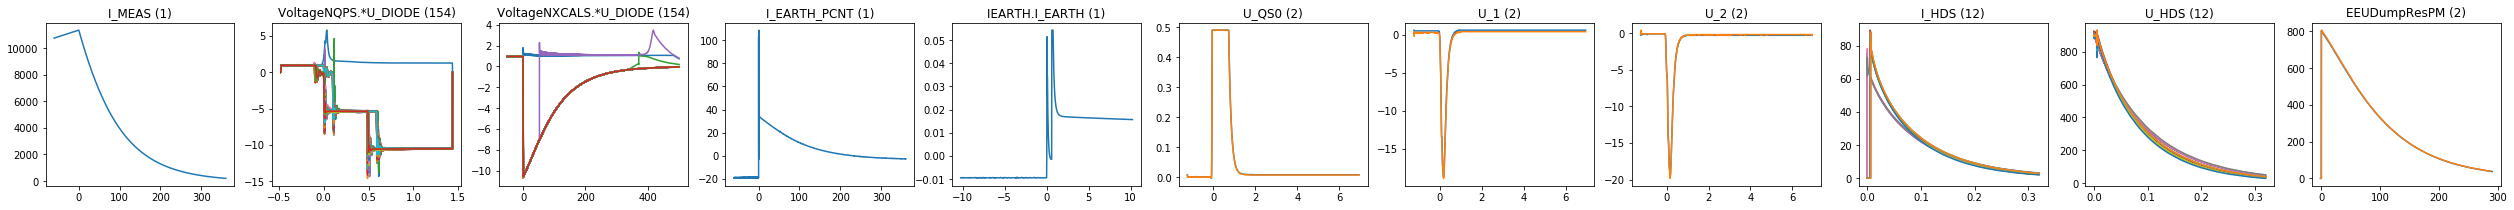

In [11]:
plot_hdf(data, column_regex=signals)

## Query all FGC events

In [6]:
# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= 1609455600000000000].reset_index(drop=True) 
len(mp3_fpa_df_period)

signals = ['I_MEAS','VoltageNQPS.*U_DIODE','VoltageNXCALS.*U_DIODE','I_EARTH_PCNT', 'IEARTH.I_EARTH','U_QS0','U_1','U_2','I_HDS', 'U_HDS','EEUDumpResPM']

In [9]:
for index, row in mp3_fpa_df_period.iterrows():
    
    fpa_identifier = {'circuit_type': row['Circuit Family'],
                      'circuit_name': row['Circuit Name'],
                      'timestamp_fgc': int(row['timestamp_fgc'])}
    file_name = f"{fpa_identifier['circuit_type']}_{fpa_identifier['circuit_name']}_{fpa_identifier['timestamp_fgc']}.hdf5"
    Path(file_dir / Path('20220707_plots')).mkdir(parents=True, exist_ok=True)
    
    if not os.path.isfile(str(file_dir / Path('20220707_plots') / f"{fpa_identifier['circuit_type']}_{fpa_identifier['circuit_name']}_{fpa_identifier['timestamp_fgc']}.png")):
        for signal_group in signal_groups:
            group = signal_group(**fpa_identifier, spark=spark)
            acquisition_to_hdf5(acquisition=group, 
                                file_dir=file_dir,
                                context_dir_name="20220707_context",
                                failed_queries_dir_name="20220707_failed",
                                data_dir_name="20220707_data")

        #log_acquisition(identifier=fpa_identifier, log_data={"download_complete": True}, log_path=context_path)

        file_path = file_dir / Path('20220707_data') / file_name
        data = load_from_hdf_with_regex(file_path)
        fig = plt.figure(figsize=(20, 15))
        for i, s in enumerate(signals):
            fig.add_subplot(4, 3, i+1)
            n_signals = 0
            for df in data:
                if bool(re.search(s, df.columns.values[0])):
                    plt.plot(df.index.values, df.values)
                    n_signals += 1
            plt.title(f"{s} ({n_signals})")

        plt.savefig(str(file_dir / Path('20220707_plots') / f"{fpa_identifier['circuit_type']}_{fpa_identifier['circuit_name']}_{fpa_identifier['timestamp_fgc']}.png"))
        plt.close()
    else:
        print(f"done: {file_name}")

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-05 18:33:44.460
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-05 18:32:54.460 to 2021-03-05 18:42:04.460
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-05 18:32:54.460 to 2021-03-05 18:42:04.460
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-05 18:33:34.460 to 2021-03-05 18:40:24.460
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-05 18:33:34.460 to 2021-03-05 18:33:54.460


Post Mortem returned no data for the following query: http://pm-rest.cern.ch/v2//pmdata/header/within/duration?system=QPS&className=DQAMGNSRB_PMREL&source=*&fromTimestampInNanos=1614965614460000000&durationInNanos=410000000000
Some nQPS PM buffers missing. ['B8R7', 'B9R7', 'B10R7', 'B11R7', 'B12R7', 'B13R7', 'B14R7', 'B15R7', 'B16R7', 'B17R7', 'B18R7', 'B19R7', 'B20R7', 'B21R7', 'B22R7', 'B23R7', 'B24R7', 'B25R7', 'B26R7', 'B27R7', 'B28R7', 'B29R7', 'B30R7', 'B31R7', 'B32R7', 'B33R7', 'B34R7', 'B34L8', 'B33L8', 'B32L8', 'B31L8', 'B30L8', 'B29L8', 'B28L8', 'B27L8', 'B26L8', 'B25L8', 'B24L8', 'B23L8', 'B22L8', 'B21L8', 'B20L8', 'B19L8', 'B18L8', 'B17L8', 'B16L8', 'B15L8', 'B14L8', 'B13L8', 'B12L8', 'B11L8', 'B10L8', 'B9L8', 'B8L8'] not found for RB.A78 within [(10, 's'), (400, 's')] around 1614965624460000000.


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-05 18:33:34.460 to 2021-03-05 18:50:24.460
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-05 18:33:34.460 to 2021-03-05 18:50:24.460
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-05 18:33:44.523
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-05 18:33:45.018
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-05 18:33:34.460 to 2021-03-05 18:42:04.460


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-08 08:50:48.140
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-08 08:49:58.140 to 2021-03-08 08:59:08.140
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-08 08:49:58.140 to 2021-03-08 08:59:08.140
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-08 08:50:38.140 to 2021-03-08 08:57:28.140
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-08 08:50:38.140 to 2021-03-08 08:50:58.140


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-08 08:50:38.140 to 2021-03-08 09:07:28.140
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-08 08:50:38.140 to 2021-03-08 09:07:28.140
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-08 08:50:48.212
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-08 08:50:48.711
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-08 08:50:38.140 to 2021-03-08 08:59:08.140


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-08 14:39:07.420
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-08 14:38:17.420 to 2021-03-08 14:47:27.420
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-08 14:38:17.420 to 2021-03-08 14:47:27.420
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-08 14:38:57.420 to 2021-03-08 14:45:47.420
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-08 14:38:57.420 to 2021-03-08 14:39:17.420


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-08 14:38:57.420 to 2021-03-08 14:55:47.420
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-08 14:38:57.420 to 2021-03-08 14:55:47.420
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-08 14:39:07.494
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-08 14:39:07.993
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-08 14:38:57.420 to 2021-03-08 14:47:27.420


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-09 07:39:33.700
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-09 07:38:43.700 to 2021-03-09 07:47:53.700
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-09 07:38:43.700 to 2021-03-09 07:47:53.700
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-09 07:39:23.700 to 2021-03-09 07:46:13.700
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-09 07:39:23.700 to 2021-03-09 07:39:43.700


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-09 07:39:23.700 to 2021-03-09 07:56:13.700
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-09 07:39:23.700 to 2021-03-09 07:56:13.700
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-09 07:39:33.773
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-09 07:39:34.268
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-09 07:39:23.700 to 2021-03-09 07:47:53.700


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-09 17:51:03.520
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-09 17:50:13.520 to 2021-03-09 17:59:23.520
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-09 17:50:13.520 to 2021-03-09 17:59:23.520
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-09 17:50:53.520 to 2021-03-09 17:57:43.520
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-09 17:50:53.520 to 2021-03-09 17:51:13.520


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-09 17:50:53.520 to 2021-03-09 18:07:43.520
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-09 17:50:53.520 to 2021-03-09 18:07:43.520
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-09 17:51:03.593
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-09 17:51:04.088



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-09 17:50:53.520 to 2021-03-09 17:59:23.520


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-10 09:03:22.260
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-10 09:02:32.260 to 2021-03-10 09:11:42.260
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-10 09:02:32.260 to 2021-03-10 09:11:42.260
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-10 09:03:12.260 to 2021-03-10 09:10:02.260
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-10 09:03:12.260 to 2021-03-10 09:03:32.260


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-10 09:03:12.260 to 2021-03-10 09:20:02.260
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-10 09:03:12.260 to 2021-03-10 09:20:02.260
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-10 09:03:22.319
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-10 09:03:22.814
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-10 09:03:12.260 to 2021-03-10 09:11:42.260


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-10 17:37:01.340
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-10 17:36:11.340 to 2021-03-10 17:45:21.340
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-10 17:36:11.340 to 2021-03-10 17:45:21.340
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-10 17:36:51.340 to 2021-03-10 17:43:41.340
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-10 17:36:51.340 to 2021-03-10 17:37:11.340


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-10 17:36:51.340 to 2021-03-10 17:53:41.340
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-10 17:36:51.340 to 2021-03-10 17:53:41.340
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-10 17:37:01.401
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-10 17:37:01.897
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-10 17:36:51.340 to 2021-03-10 17:45:21.340


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-11 07:26:28.700
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-11 07:25:38.700 to 2021-03-11 07:34:48.700
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-11 07:25:38.700 to 2021-03-11 07:34:48.700
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-11 07:26:18.700 to 2021-03-11 07:33:08.700
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-11 07:26:18.700 to 2021-03-11 07:26:38.700


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-11 07:26:18.700 to 2021-03-11 07:43:08.700
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-11 07:26:18.700 to 2021-03-11 07:43:08.700
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-11 07:26:28.771
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-11 07:26:29.266
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-11 07:26:18.700 to 2021-03-11 07:34:48.700


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-11 17:53:49.600
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-11 17:52:59.600 to 2021-03-11 18:02:09.600
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-11 17:52:59.600 to 2021-03-11 18:02:09.600
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-11 17:53:39.600 to 2021-03-11 18:00:29.600
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-11 17:53:39.600 to 2021-03-11 17:53:59.600


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-11 17:53:39.600 to 2021-03-11 18:10:29.600
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-11 17:53:39.600 to 2021-03-11 18:10:29.600
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-11 17:53:49.668
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-11 17:53:50.166
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-11 17:53:39.600 to 2021-03-11 18:02:09.600


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-12 07:09:04.580
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-12 07:08:14.580 to 2021-03-12 07:17:24.580
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-12 07:08:14.580 to 2021-03-12 07:17:24.580
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-12 07:08:54.580 to 2021-03-12 07:15:44.580
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-12 07:08:54.580 to 2021-03-12 07:09:14.580


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-12 07:08:54.580 to 2021-03-12 07:25:44.580
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-12 07:08:54.580 to 2021-03-12 07:25:44.580
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-12 07:09:04.650
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-12 07:09:05.149



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-12 07:08:54.580 to 2021-03-12 07:17:24.580


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-12 17:21:05.200
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-12 17:20:15.200 to 2021-03-12 17:29:25.200
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-12 17:20:15.200 to 2021-03-12 17:29:25.200
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-12 17:20:55.200 to 2021-03-12 17:27:45.200
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-12 17:20:55.200 to 2021-03-12 17:21:15.200


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-12 17:20:55.200 to 2021-03-12 17:37:45.200
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-12 17:20:55.200 to 2021-03-12 17:37:45.200
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-12 17:21:05.266
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-12 17:21:05.764
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-12 17:20:55.200 to 2021-03-12 17:29:25.200


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-13 08:59:49.080
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-13 08:58:59.080 to 2021-03-13 09:08:09.080
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-13 08:58:59.080 to 2021-03-13 09:08:09.080
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-13 08:59:39.080 to 2021-03-13 09:06:29.080
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-13 08:59:39.080 to 2021-03-13 08:59:59.080


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-13 08:59:39.080 to 2021-03-13 09:16:29.080
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-13 08:59:39.080 to 2021-03-13 09:16:29.080
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-13 08:59:49.140
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-13 08:59:49.636
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-13 08:59:39.080 to 2021-03-13 09:08:09.080


Querying PM:   0%|          | 0/8 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-13 18:46:40.480
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-13 18:45:50.480 to 2021-03-13 18:55:00.480
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-13 18:45:50.480 to 2021-03-13 18:55:00.480
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-13 18:46:30.480 to 2021-03-13 18:53:20.480
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-13 18:46:30.480 to 2021-03-13 18:46:50.480


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-13 18:46:30.480 to 2021-03-13 19:03:20.480
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-13 18:46:30.480 to 2021-03-13 19:03:20.480
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-13 18:46:40.552



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-13 18:46:41.048
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-13 18:46:30.480 to 2021-03-13 18:55:00.480


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-14 09:05:36.200
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-14 09:04:46.200 to 2021-03-14 09:13:56.200
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-14 09:04:46.200 to 2021-03-14 09:13:56.200
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-14 09:05:26.200 to 2021-03-14 09:12:16.200
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-14 09:05:26.200 to 2021-03-14 09:05:46.200


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-14 09:05:26.200 to 2021-03-14 09:22:16.200
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-14 09:05:26.200 to 2021-03-14 09:22:16.200
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-14 09:05:36.259
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-14 09:05:36.758



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-14 09:05:26.200 to 2021-03-14 09:13:56.200


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-14 18:14:57.640
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-14 18:14:07.640 to 2021-03-14 18:23:17.640
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-14 18:14:07.640 to 2021-03-14 18:23:17.640
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-14 18:14:47.640 to 2021-03-14 18:21:37.640
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-14 18:14:47.640 to 2021-03-14 18:15:07.640


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-14 18:14:47.640 to 2021-03-14 18:31:37.640
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-14 18:14:47.640 to 2021-03-14 18:31:37.640
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-14 18:14:57.706
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-14 18:14:58.201
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-14 18:14:47.640 to 2021-03-14 18:23:17.640


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-15 07:08:36.120
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-15 07:07:46.120 to 2021-03-15 07:16:56.120
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-15 07:07:46.120 to 2021-03-15 07:16:56.120
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-15 07:08:26.120 to 2021-03-15 07:15:16.120
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-15 07:08:26.120 to 2021-03-15 07:08:46.120


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-15 07:08:26.120 to 2021-03-15 07:25:16.120
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-15 07:08:26.120 to 2021-03-15 07:25:16.120
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-15 07:08:36.196
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-15 07:08:36.692
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-15 07:08:26.120 to 2021-03-15 07:16:56.120


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-16 21:57:17.080
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-16 21:56:27.080 to 2021-03-16 22:05:37.080
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-16 21:56:27.080 to 2021-03-16 22:05:37.080
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-16 21:57:07.080 to 2021-03-16 22:03:57.080
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-16 21:57:07.080 to 2021-03-16 21:57:27.080


Post Mortem returned no data for the following query: http://pm-rest.cern.ch/v2//pmdata/header/within/duration?system=QPS&className=DQAMGNSRB_PMREL&source=*&fromTimestampInNanos=1615928227080000000&durationInNanos=410000000000
Some nQPS PM buffers missing. ['B8R3', 'B9R3', 'B10R3', 'B11R3', 'B12R3', 'B13R3', 'B14R3', 'B15R3', 'B16R3', 'B17R3', 'B18R3', 'B19R3', 'B20R3', 'B21R3', 'B22R3', 'B23R3', 'B24R3', 'B25R3', 'B26R3', 'B27R3', 'B28R3', 'B29R3', 'B30R3', 'B31R3', 'B32R3', 'B33R3', 'B34R3', 'B34L4', 'B33L4', 'B32L4', 'B31L4', 'B30L4', 'B29L4', 'B28L4', 'B27L4', 'B26L4', 'B25L4', 'B24L4', 'B23L4', 'B22L4', 'B21L4', 'B20L4', 'B19L4', 'B18L4', 'B17L4', 'B16L4', 'B15L4', 'B14L4', 'B13L4', 'B12L4', 'B11L4', 'B10L4', 'B9L4', 'B8L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1615928237080000000.


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-16 21:57:07.080 to 2021-03-16 22:13:57.080
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-16 21:57:07.080 to 2021-03-16 22:13:57.080
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-16 21:57:17.155
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-16 21:57:17.652
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-16 21:57:07.080 to 2021-03-16 22:05:37.080


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-26 17:44:29.680
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-26 17:43:39.680 to 2021-03-26 17:52:49.680
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-26 17:43:39.680 to 2021-03-26 17:52:49.680
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-26 17:44:19.680 to 2021-03-26 17:51:09.680
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-26 17:44:19.680 to 2021-03-26 17:44:39.680


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-26 17:44:19.680 to 2021-03-26 18:01:09.680
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-26 17:44:19.680 to 2021-03-26 18:01:09.680
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-26 17:44:29.750
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-26 17:44:30.246
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-26 17:44:19.680 to 2021-03-26 17:52:49.680


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-27 07:34:43
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-27 07:33:53 to 2021-03-27 07:43:03
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-27 07:33:53 to 2021-03-27 07:43:03
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-27 07:34:33 to 2021-03-27 07:41:23
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-27 07:34:33 to 2021-03-27 07:34:53


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-27 07:34:33 to 2021-03-27 07:51:23
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-27 07:34:33 to 2021-03-27 07:51:23
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-27 07:34:43.058



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-27 07:34:43.556
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-27 07:34:33 to 2021-03-27 07:43:03


Querying PM:   0%|          | 0/10 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-27 09:06:14.440
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-27 09:05:24.440 to 2021-03-27 09:14:34.440
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-27 09:05:24.440 to 2021-03-27 09:14:34.440
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-27 09:06:04.440 to 2021-03-27 09:12:54.440
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-27 09:06:04.440 to 2021-03-27 09:06:24.440


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-27 09:06:04.440 to 2021-03-27 09:22:54.440
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-27 09:06:04.440 to 2021-03-27 09:22:54.440
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-27 09:06:14.501
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-27 09:06:15.001
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-27 09:06:04.440 to 2021-03-27 09:14:34.440


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-27 18:19:22.720
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-27 18:18:32.720 to 2021-03-27 18:27:42.720
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-27 18:18:32.720 to 2021-03-27 18:27:42.720
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-27 18:19:12.720 to 2021-03-27 18:26:02.720
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-27 18:19:12.720 to 2021-03-27 18:19:32.720


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-27 18:19:12.720 to 2021-03-27 18:36:02.720
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-27 18:19:12.720 to 2021-03-27 18:36:02.720
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-27 18:19:22.783
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-27 18:19:23.280



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-27 18:19:12.720 to 2021-03-27 18:27:42.720


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-28 09:41:29.180
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-28 09:40:39.180 to 2021-03-28 09:49:49.180
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-28 09:40:39.180 to 2021-03-28 09:49:49.180
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-28 09:41:19.180 to 2021-03-28 09:48:09.180
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-28 09:41:19.180 to 2021-03-28 09:41:39.180


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-28 09:41:19.180 to 2021-03-28 09:58:09.180
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-28 09:41:19.180 to 2021-03-28 09:58:09.180
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-28 09:41:29.241
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-28 09:41:29.741
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-28 09:41:19.180 to 2021-03-28 09:49:49.180


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-28 15:44:46
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-28 15:43:56 to 2021-03-28 15:53:06
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-28 15:43:56 to 2021-03-28 15:53:06
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-28 15:44:36 to 2021-03-28 15:51:26
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-28 15:44:36 to 2021-03-28 15:44:56


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-28 15:44:36 to 2021-03-28 16:01:26
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-28 15:44:36 to 2021-03-28 16:01:26
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-28 15:44:46.066
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-28 15:44:46.564
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-28 15:44:36 to 2021-03-28 15:53:06


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-28 22:09:34.400
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-28 22:08:44.400 to 2021-03-28 22:17:54.400
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-28 22:08:44.400 to 2021-03-28 22:17:54.400
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-28 22:09:24.400 to 2021-03-28 22:16:14.400
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-28 22:09:24.400 to 2021-03-28 22:09:44.400


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-28 22:09:24.400 to 2021-03-28 22:26:14.400
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-28 22:09:24.400 to 2021-03-28 22:26:14.400
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-28 22:09:34.462
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-28 22:09:34.960
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-28 22:09:24.400 to 2021-03-28 22:17:54.400


Querying PM:   0%|          | 0/5 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-28 23:08:14.360
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-28 23:07:24.360 to 2021-03-28 23:16:34.360
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-28 23:07:24.360 to 2021-03-28 23:16:34.360
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-28 23:08:04.360 to 2021-03-28 23:14:54.360
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-28 23:08:04.360 to 2021-03-28 23:08:24.360


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-28 23:08:04.360 to 2021-03-28 23:24:54.360
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-28 23:08:04.360 to 2021-03-28 23:24:54.360
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-28 23:08:14.418
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-28 23:08:14.918
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-28 23:08:04.360 to 2021-03-28 23:16:34.360


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-29 07:59:40.340
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-29 07:58:50.340 to 2021-03-29 08:08:00.340
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-29 07:58:50.340 to 2021-03-29 08:08:00.340
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-29 07:59:30.340 to 2021-03-29 08:06:20.340
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-29 07:59:30.340 to 2021-03-29 07:59:50.340


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-29 07:59:30.340 to 2021-03-29 08:16:20.340
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-29 07:59:30.340 to 2021-03-29 08:16:20.340
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-29 07:59:40.408
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-29 07:59:40.907
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-29 07:59:30.340 to 2021-03-29 08:08:00.340


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-29 18:28:56.080
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-29 18:28:06.080 to 2021-03-29 18:37:16.080
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-29 18:28:06.080 to 2021-03-29 18:37:16.080
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-29 18:28:46.080 to 2021-03-29 18:35:36.080
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-29 18:28:46.080 to 2021-03-29 18:29:06.080


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-29 18:28:46.080 to 2021-03-29 18:45:36.080
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-29 18:28:46.080 to 2021-03-29 18:45:36.080
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-29 18:28:56.152
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-29 18:28:56.648



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-29 18:28:46.080 to 2021-03-29 18:37:16.080


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-29 19:27:43.620
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-29 19:26:53.620 to 2021-03-29 19:36:03.620
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-29 19:26:53.620 to 2021-03-29 19:36:03.620
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-29 19:27:33.620 to 2021-03-29 19:34:23.620
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-29 19:27:33.620 to 2021-03-29 19:27:53.620


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-29 19:27:33.620 to 2021-03-29 19:44:23.620
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-29 19:27:33.620 to 2021-03-29 19:44:23.620
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-29 19:27:43.676
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-29 19:27:44.175
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-29 19:27:33.620 to 2021-03-29 19:36:03.620


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-30 07:14:12.900
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-30 07:13:22.900 to 2021-03-30 07:22:32.900
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-30 07:13:22.900 to 2021-03-30 07:22:32.900
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-30 07:14:02.900 to 2021-03-30 07:20:52.900
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-30 07:14:02.900 to 2021-03-30 07:14:22.900


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-30 07:14:02.900 to 2021-03-30 07:30:52.900
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-30 07:14:02.900 to 2021-03-30 07:30:52.900
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-30 07:14:12.973
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-30 07:14:13.469
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-30 07:14:02.900 to 2021-03-30 07:22:32.900


Querying PM:   0%|          | 0/7 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-30 07:47:12.740
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-30 07:46:22.740 to 2021-03-30 07:55:32.740
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-30 07:46:22.740 to 2021-03-30 07:55:32.740
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-30 07:47:02.740 to 2021-03-30 07:53:52.740
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-30 07:47:02.740 to 2021-03-30 07:47:22.740


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-30 07:47:02.740 to 2021-03-30 08:03:52.740
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-30 07:47:02.740 to 2021-03-30 08:03:52.740
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-30 07:47:12.812
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-30 07:47:13.311
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-30 07:47:02.740 to 2021-03-30 07:55:32.740


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-30 18:07:45.340
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-30 18:06:55.340 to 2021-03-30 18:16:05.340
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-30 18:06:55.340 to 2021-03-30 18:16:05.340
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-30 18:07:35.340 to 2021-03-30 18:14:25.340
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-30 18:07:35.340 to 2021-03-30 18:07:55.340


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-30 18:07:35.340 to 2021-03-30 18:24:25.340
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-30 18:07:35.340 to 2021-03-30 18:24:25.340
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-30 18:07:45.400
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-30 18:07:45.897
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-30 18:07:35.340 to 2021-03-30 18:16:05.340


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-30 18:57:38.120
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-30 18:56:48.120 to 2021-03-30 19:05:58.120
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-30 18:56:48.120 to 2021-03-30 19:05:58.120
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-30 18:57:28.120 to 2021-03-30 19:04:18.120
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-30 18:57:28.120 to 2021-03-30 18:57:48.120


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-30 18:57:28.120 to 2021-03-30 19:14:18.120
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-30 18:57:28.120 to 2021-03-30 19:14:18.120
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-30 18:57:38.177



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-30 18:57:38.673
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-30 18:57:28.120 to 2021-03-30 19:05:58.120


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-03-31 07:29:03.820
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-03-31 07:28:13.820 to 2021-03-31 07:37:23.820
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-03-31 07:28:13.820 to 2021-03-31 07:37:23.820
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-31 07:28:53.820 to 2021-03-31 07:35:43.820
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-31 07:28:53.820 to 2021-03-31 07:29:13.820


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-03-31 07:28:53.820 to 2021-03-31 07:45:43.820
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-03-31 07:28:53.820 to 2021-03-31 07:45:43.820
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-03-31 07:29:03.895
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-03-31 07:29:04.395
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-31 07:28:53.820 to 2021-03-31 07:37:23.820


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-31 07:57:35.140
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-31 07:56:45.140 to 2021-03-31 08:05:55.140
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-31 07:56:45.140 to 2021-03-31 08:05:55.140
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-31 07:57:25.140 to 2021-03-31 08:04:15.140
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-31 07:57:25.140 to 2021-03-31 07:57:45.140


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-31 07:57:25.140 to 2021-03-31 08:14:15.140
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-31 07:57:25.140 to 2021-03-31 08:14:15.140
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-31 07:57:35.212
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-31 07:57:35.710
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-31 07:57:25.140 to 2021-03-31 08:05:55.140


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-03-31 20:09:45.940
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-03-31 20:08:55.940 to 2021-03-31 20:18:05.940
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-03-31 20:08:55.940 to 2021-03-31 20:18:05.940
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-03-31 20:09:35.940 to 2021-03-31 20:16:25.940
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-03-31 20:09:35.940 to 2021-03-31 20:09:55.940


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-03-31 20:09:35.940 to 2021-03-31 20:26:25.940
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-03-31 20:09:35.940 to 2021-03-31 20:26:25.940
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-03-31 20:09:46.001
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-03-31 20:09:46.496
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-03-31 20:09:35.940 to 2021-03-31 20:18:05.940


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-01 07:16:02.380
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-01 07:15:12.380 to 2021-04-01 07:24:22.380
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-01 07:15:12.380 to 2021-04-01 07:24:22.380
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-01 07:15:52.380 to 2021-04-01 07:22:42.380
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-01 07:15:52.380 to 2021-04-01 07:16:12.380


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-01 07:15:52.380 to 2021-04-01 07:32:42.380
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-01 07:15:52.380 to 2021-04-01 07:32:42.380
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-01 07:16:02.454
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-01 07:16:02.952
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-01 07:15:52.380 to 2021-04-01 07:24:22.380


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-01 17:23:29.520
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-01 17:22:39.520 to 2021-04-01 17:31:49.520
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-04-01 17:22:39.520 to 2021-04-01 17:31:49.520
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-01 17:23:19.520 to 2021-04-01 17:30:09.520
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-01 17:23:19.520 to 2021-04-01 17:23:39.520


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-04-01 17:23:19.520 to 2021-04-01 17:40:09.520
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-04-01 17:23:19.520 to 2021-04-01 17:40:09.520
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-04-01 17:23:29.594
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-04-01 17:23:30.091
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-01 17:23:19.520 to 2021-04-01 17:31:49.520


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-01 19:25:10.840
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-01 19:24:20.840 to 2021-04-01 19:33:30.840
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-01 19:24:20.840 to 2021-04-01 19:33:30.840
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-01 19:25:00.840 to 2021-04-01 19:31:50.840
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-01 19:25:00.840 to 2021-04-01 19:25:20.840


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-01 19:25:00.840 to 2021-04-01 19:41:50.840
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-01 19:25:00.840 to 2021-04-01 19:41:50.840
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-01 19:25:10.915
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-01 19:25:11.410
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-01 19:25:00.840 to 2021-04-01 19:33:30.840


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-02 07:04:10.740
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-02 07:03:20.740 to 2021-04-02 07:12:30.740
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-02 07:03:20.740 to 2021-04-02 07:12:30.740
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-02 07:04:00.740 to 2021-04-02 07:10:50.740
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-02 07:04:00.740 to 2021-04-02 07:04:20.740


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-02 07:04:00.740 to 2021-04-02 07:20:50.740
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-02 07:04:00.740 to 2021-04-02 07:20:50.740
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-02 07:04:10.798
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-02 07:04:11.295
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-02 07:04:00.740 to 2021-04-02 07:12:30.740


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-02 07:43:51.140
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-02 07:43:01.140 to 2021-04-02 07:52:11.140
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-04-02 07:43:01.140 to 2021-04-02 07:52:11.140
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-02 07:43:41.140 to 2021-04-02 07:50:31.140
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-02 07:43:41.140 to 2021-04-02 07:44:01.140


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-04-02 07:43:41.140 to 2021-04-02 08:00:31.140
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-04-02 07:43:41.140 to 2021-04-02 08:00:31.140
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-04-02 07:43:51.203
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-04-02 07:43:51.703
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-02 07:43:41.140 to 2021-04-02 07:52:11.140


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-02 18:01:29.280
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-02 18:00:39.280 to 2021-04-02 18:09:49.280
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-02 18:00:39.280 to 2021-04-02 18:09:49.280
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-02 18:01:19.280 to 2021-04-02 18:08:09.280
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-02 18:01:19.280 to 2021-04-02 18:01:39.280


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-02 18:01:19.280 to 2021-04-02 18:18:09.280
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-02 18:01:19.280 to 2021-04-02 18:18:09.280
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-02 18:01:29.355
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-02 18:01:29.851
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-02 18:01:19.280 to 2021-04-02 18:09:49.280


Querying PM:   0%|          | 0/3 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-02 20:56:47.160
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-02 20:55:57.160 to 2021-04-02 21:05:07.160
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-04-02 20:55:57.160 to 2021-04-02 21:05:07.160
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-02 20:56:37.160 to 2021-04-02 21:03:27.160
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-02 20:56:37.160 to 2021-04-02 20:56:57.160


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-04-02 20:56:37.160 to 2021-04-02 21:13:27.160
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-04-02 20:56:37.160 to 2021-04-02 21:13:27.160
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-04-02 20:56:47.225
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-04-02 20:56:47.725
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-02 20:56:37.160 to 2021-04-02 21:05:07.160


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-03 07:04:51.140
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-03 07:04:01.140 to 2021-04-03 07:13:11.140
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-04-03 07:04:01.140 to 2021-04-03 07:13:11.140
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-03 07:04:41.140 to 2021-04-03 07:11:31.140
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-03 07:04:41.140 to 2021-04-03 07:05:01.140


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-04-03 07:04:41.140 to 2021-04-03 07:21:31.140
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-04-03 07:04:41.140 to 2021-04-03 07:21:31.140
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-04-03 07:04:51.201
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-04-03 07:04:51.698
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-03 07:04:41.140 to 2021-04-03 07:13:11.140


Querying PM:   0%|          | 0/9 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-03 08:23:21.300
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-03 08:22:31.300 to 2021-04-03 08:31:41.300
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-03 08:22:31.300 to 2021-04-03 08:31:41.300
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-03 08:23:11.300 to 2021-04-03 08:30:01.300
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-03 08:23:11.300 to 2021-04-03 08:23:31.300


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-03 08:23:11.300 to 2021-04-03 08:40:01.300
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-03 08:23:11.300 to 2021-04-03 08:40:01.300
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-03 08:23:21.359
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-03 08:23:21.855
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-03 08:23:11.300 to 2021-04-03 08:31:41.300


Querying PM:   0%|          | 0/8 [00:00<?, ?it/s]

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-03 17:56:27.780
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-03 17:55:37.780 to 2021-04-03 18:04:47.780
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-03 17:55:37.780 to 2021-04-03 18:04:47.780
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-03 17:56:17.780 to 2021-04-03 18:03:07.780
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-03 17:56:17.780 to 2021-04-03 17:56:37.780


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-03 17:56:17.780 to 2021-04-03 18:13:07.780
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-03 17:56:17.780 to 2021-04-03 18:13:07.780
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-03 17:56:27.844
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-03 17:56:28.343
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-03 17:56:17.780 to 2021-04-03 18:04:47.780


Querying PM:   0%|          | 0/8 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-03 18:28:40.360
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-03 18:27:50.360 to 2021-04-03 18:37:00.360
	Querying NXCALS signal(s) MB.A9R3:U_EARTH_RB, DFLAS.7R3.1:U_EARTH_RB, MB.A12R3:U_EARTH_RB, MB.B9R3:U_EARTH_RB, MB.A14R3:U_EARTH_RB... from 2021-04-03 18:27:50.360 to 2021-04-03 18:37:00.360
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-03 18:28:30.360 to 2021-04-03 18:35:20.360


Some nQPS PM buffers missing. ['B19L4'] not found for RB.A34 within [(10, 's'), (400, 's')] around 1617467320360000000.


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-03 18:28:30.360 to 2021-04-03 18:28:50.360


Querying PM:   0%|          | 0/2 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/2 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 from 2021-04-03 18:28:30.360 to 2021-04-03 18:45:20.360
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 from 2021-04-03 18:28:30.360 to 2021-04-03 18:45:20.360
	Querying PM event signal(s) UJ33.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UJ33.RB.A34 at 2021-04-03 18:28:40.434
	Querying PM event signal(s) UA43.RB.A34:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA43.RB.A34 at 2021-04-03 18:28:40.934
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-03 18:28:30.360 to 2021-04-03 18:37:00.360


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA83.RB.A78 at 2021-04-04 07:44:38.940
	Querying NXCALS signal(s) MB.A8R7:U_DIODE_RB, MB.B8R7:U_DIODE_RB, MB.A9R7:U_DIODE_RB, MB.B9R7:U_DIODE_RB, MB.A10R7:U_DIODE_RB... from 2021-04-04 07:43:48.940 to 2021-04-04 07:52:58.940
	Querying NXCALS signal(s) DFLAS.7R7.2:U_EARTH_RB, MB.B9R7:U_EARTH_RB, MB.A9R7:U_EARTH_RB, MB.B12R7:U_EARTH_RB, MB.A12R7:U_EARTH_RB... from 2021-04-04 07:43:48.940 to 2021-04-04 07:52:58.940
	Querying PM event timestamps for system: QPS, className: DQAMGNSRB_PMREL, source: * from 2021-04-04 07:44:28.940 to 2021-04-04 07:51:18.940
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2021-04-04 07:44:28.940 to 2021-04-04 07:44:48.940


Querying PM:   0%|          | 0/4 [00:00<?, ?it/s]

Querying iQPS logic PM:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 from 2021-04-04 07:44:28.940 to 2021-04-04 08:01:18.940
	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 from 2021-04-04 07:44:28.940 to 2021-04-04 08:01:18.940
	Querying PM event signal(s) RR77.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR77.RB.A78 at 2021-04-04 07:44:39
	Querying PM event signal(s) UA83.RB.A78:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA83.RB.A78 at 2021-04-04 07:44:39.496
	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMHSU, source: * from 2021-04-04 07:44:28.940 to 2021-04-04 07:52:58.940


Querying PM:   0%|          | 0/6 [00:00<?, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

	Querying PM event signal(s) STATUS.I_MEAS, IAB.I_A, IEARTH.I_EARTH, STATUS.I_EARTH_PCNT, STATUS.I_REF for system: FGC, className: lhc_self_pmd, source: RPTE.UA43.RB.A34 at 2021-04-04 08:36:50.920
	Querying NXCALS signal(s) MB.A8R3:U_DIODE_RB, MB.B8R3:U_DIODE_RB, MB.A9R3:U_DIODE_RB, MB.B9R3:U_DIODE_RB, MB.A10R3:U_DIODE_RB... from 2021-04-04 08:36:00.920 to 2021-04-04 08:45:10.920


KeyboardInterrupt: 